In [49]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [50]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_5697/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [51]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [52]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [53]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'days_stat1b', 'creat_li', 'doncrit_max_peak_sgot', 'mcsdwithrhfprostacyclin', 'mech_circ_30days', 'malig_don_rel_27_dx_date', 'end_bmi_calc', 'withdrawal_time', 'tumor_size2', 'ovarian_donor', 'tbili_tx', 'urine_inf_don', 'pcwp_post_don', 'criteriamcsdmalfunction', 'reop_bowel_li', 'serum', 'mr_hemoglobin_a1c', 'leuk', 'intubated_dt', 'cpra', 'hemocvp', 'doncrit_max_pct_scler_lt10gl_imp', 'ecmowithouthemoalt', 'pramr_cl2', 'washout3', 'mcsdwithrhfvenpressure', 'currtherotherdiureticdose', 'high_pco2_ph', 'iabpcardiacindexdt', 'washout2', 'kaposi_visceral', 'o2', 'ventricularepisode', 'length_left_lung', 'val_dt_ddr', 'calc_fvc_abs', 'reop_li_fail', 'other', 'vent_timeframe_trr', 'extcardiacindex', 'inr_tx', 'sacrifice_lobe', 'contrast4', 'tongue_throat_donor', 'grf_fail_dt', 'hemopasp', 'admittedtohospital', 'fev_post_act', 'doncrit_max_peak_inr', 'final_ctp_score', 'peripheral_rim7', 'mcsdinfectiondebridement', 'extinotropedopamine', 'exc_meld_peld_lab', 'larynx',

Let's investigate the columns with unknown type.

In [54]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [55]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'myfortic_ind', 'oth_drug_ind2', 'steroids_ind', 'genericmmf_maint', 'prograf_ind', 'alg_maint', 'genericcyclosporin_ind', 'zenapax_ind', 'steroids_maint', 'cellcept_ind', 'antiicam1_maint', 'eon_maint', 'cyclosporin_maint', 'zenapax_maint', 'zortress_maint', 'envarsusxr_maint', 'nratgnrats_ind', 'sangcya_maint', 'nratgnrats_maint', 'genericsirolimus_ind', 'cyclosporin_ind', 'neoral_ind', 'deoxyspergualin_ind', 'cellcept_maint', 'okt3_maint', 'simulect_ind', 'campath_ind', 'fty720_ind', 'leflunomide_maint', 'cytoxan_ind', 'leflunomide_ind', 'genericsirolimus_maint', 'gengraf_maint', 'genericcyclosporin_maint', 'simulect_maint', 'xomazymecd5_ind', 'cytoxan_maint', 'brequinarsodium_ind', 'xomazymecd5_maint', 'methotrexate_maint', 'dab486il2_maint', 'aldesleukin_maint', 'envarsusxr_ind', 'aldesleukin_ind', 'antitnf_ind', 'sandimmune_ind', 'anti

Let's investigate the types of these columns.

In [56]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

0.00000    2028
1.00000       1
Name: myfortic_ind, dtype: int64
0.00000    181
1.00000    159
Name: oth_drug_ind2, dtype: int64
1.00000    49656
0.00000    19133
Name: steroids_ind, dtype: int64
1.00000    10816
Name: genericmmf_maint, dtype: int64
0.00000    25773
1.00000      552
Name: prograf_ind, dtype: int64
0.00000    22
1.00000    17
Name: alg_maint, dtype: int64
0.00000    255
1.00000      2
Name: genericcyclosporin_ind, dtype: int64
1.00000    3048
0.00000     209
Name: zenapax_ind, dtype: int64
1.00000    64044
0.00000     4745
Name: steroids_maint, dtype: int64
0.00000    33356
1.00000     2755
Name: cellcept_ind, dtype: int64
0.00000    9
Name: antiicam1_maint, dtype: int64
1.00000    137
0.00000     13
Name: eon_maint, dtype: int64
1.00000    10117
0.00000      152
Name: cyclosporin_maint, dtype: int64
0.00000    3012
1.00000     245
Name: zenapax_maint, dtype: int64
1.00000    240
0.00000     31
Name: zortress_maint, dtype: int64
1.00000    88
Name: envarsusxr_maint, dty

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [57]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [58]:
# sort columns by number of unique values
categoric_sorted_unique = d[list(categorical_columns & set(d.columns))].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

cod                         76
cod_wl                      63
thoracic_dgn                56
malig_ty_tcr                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_tcr               25
func_stat_trf               25
func_stat_trr               25
rem_cd                      18
end_stat                    11
init_stat                   11
abo                          9
abo_don                      9
tcr_dur_abstain              9
ethcat_don                   8
ethcat                       8
vad_tah_tcr                  8
broncho_lt_don               8
vad_tah_trr                  8
broncho_rt_don               8
education                    8
chest_xray_don               7
academic_level_trr           6
hist_diabetes_don            6
vad_device_ty_trr            6
diab                         6
vad_device_ty_tcr            6
cognitive_dev_trr            5
motor_dev_trr                5
academic_prg_trr             5
academic_prg_tcr             5
dial_ty_

Let's similarly investigate if any numeric columns have too few unique values.

In [59]:
numeric_sorted_unique = d[list(numerical_columns & set(d.columns))].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
lvad_at_listing                      1
rvad_at_listing                      1
rvad_while_listed                    1
lvad_while_listed                    1
pco2_trr                             1
pge_trr                              2
fvc_trr                              2
inotropes_trr                        2
inotropes_tcr                        2
ventilator_tcr                       2
fev1_trr                             2
ecmo_tcr                             2
gstatus                              2
inhaled_no                           2
iabp_trr                             2
ecmo_trr                             2
iabp_tcr                             2
drmis                                3
bmis                                 3
amis                                 3
sternotomy_tcr                       4
exercise_o2                          4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [60]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [61]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [62]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

Let's additionally convert the date columns to comparable timestamps.

In [63]:
for col in date_columns:
    d[col] = pd.to_datetime(d[col], format="%d%b%Y")

# Removal of unwanted data

We want to remove all data of people under the age of 18.

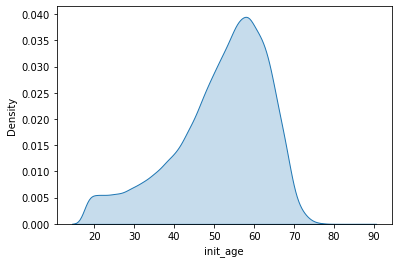

In [64]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, fill=True)
plt.show()

Furthermore, we need to somehow merge entries belonging to the same patient.

One way to handle this is to just drop all rows of patients with more than one record in the waitlist. However, this might be a bit crude if there are many patients with multiple records.

Proportion of patients with more than one record: 0.07628644895324749
0    12314
1     2917
2       84
3       13
Name: num_prev_tx, dtype: int64
0     87734
1       925
2        53
3         8
5         3
6         2
10        2
4         2
9         1
7         1
Name: num_prev_tx, dtype: int64


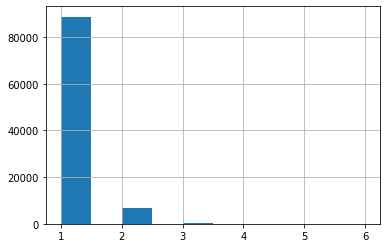

In [65]:
rcount = d.groupby("pt_code").wl_org.count()
rcount.hist()

gt1 = rcount[rcount > 1]

# print proportion of patients with at least 2 records
print("Proportion of patients with more than one record:", len(gt1) / d.pt_code.nunique())

# of those with more than one record, print the value counts for "num_prev_tx"
print(d[d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())
# num_prev_tx for those with only one record
print(d[~d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())

There are a significant amount of patients with multiple records, but by experimentation, keeping one record of each patients or removing them all patients with multiple records produced very similar results.

For now, we will remove all patients with duplicate entries.

In [66]:
#d.sort_values(by=['pt_code', 'num_prev_tx', 'init_date'], inplace=True)
#d.drop_duplicates(subset=['pt_code', 'num_prev_tx'], keep='last', inplace=True)

# Remove all patients with multiple records
d.drop_duplicates(subset=['pt_code'], keep=False, inplace=True)

There is a large amount of possible outcomes for each patient, detailed in the column rem_cd. Most of these outcomes have barely any patients assigned to them. We will filter the data set to only include the most common outcomes.

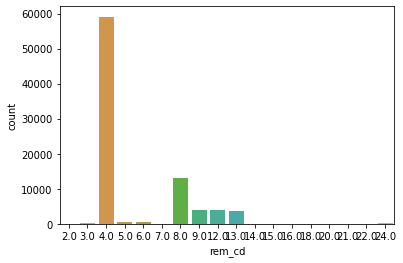

In [67]:
sns.countplot(x="rem_cd", data=d)
plt.show()

Let's remove all outcomes except the most common: [4,8,9,12,13]

In [68]:
d = d[d.rem_cd.isna() | d.rem_cd.isin([4,8,13])] # not 9 = other, 12 = improved

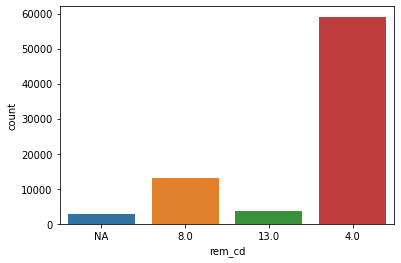

In [69]:
sns.countplot(x="rem_cd", data=d.fillna("NA"))
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

In [70]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()

d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns].lt(upper)) & (d2[numerical_columns].gt(lower))]
d, d2 = d2, d

Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

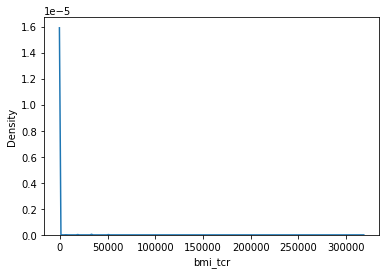

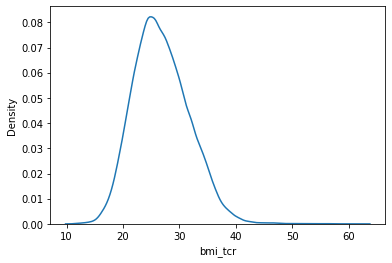

In [71]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [72]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]
selected_vars.remove("init_creat") # only contains missing values

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 34


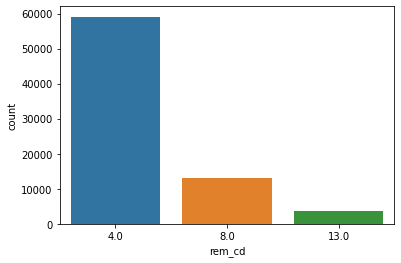

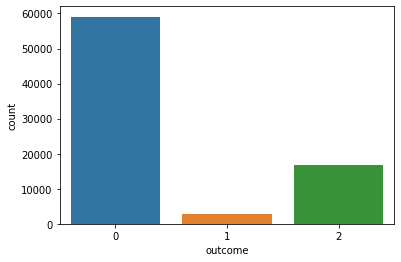

In [73]:
# 0 if transplant
# 1 if deceased
# 2 if removed for other reason
d["outcome"] = d.apply(
    lambda row: 
        0 if row.rem_cd == 4 # transplant
        else 2 if row.rem_cd in [8,13] # dies waiting
        else 1, axis=1) # other
        #1 if row.rem_cd in [8,13] # dies waiting
        #else 0, axis=1) # lives

# print distribution plot of rem_cd
sns.countplot(x="rem_cd", data=d)
plt.show()

# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [74]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True))

0   0.75087
2   0.21334
1   0.03579
Name: outcome, dtype: float64


In [75]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 26
Number date columns: 0
Number drug columns: 0


# Imputation

Let's add "missing value" columns.

In [76]:
# add missing indicator to numerical columns with missing values
for col in numerical_columns:
    if d[col].isna().any():
        d[col + "_missing"] = d[col].isna().astype(int)

Finally, let's impute the missing values.

In [77]:
# impute numerical columns with the mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())
# TODO: impute with randomness

# Normalization and encoding

Now, let's normalize numerical values.

In [78]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [79]:
d = pd.get_dummies(d, columns=categorical_columns, drop_first=False)

In [80]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 166


# Model training

Useful functions:

In [99]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_evaluation(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

def print_training_history(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)

In [100]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train_d = pd.get_dummies(y_train)
y_val_d = pd.get_dummies(y_val)
y_test_d = pd.get_dummies(y_test)

## Simple Logistic Regression Model

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11711
           1       0.81      0.55      0.66       546
           2       0.80      0.48      0.60      3479

    accuracy                           0.86     15736
   macro avg       0.83      0.67      0.73     15736
weighted avg       0.85      0.86      0.84     15736



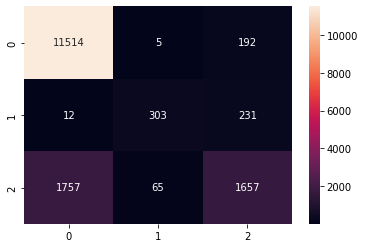

In [102]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred = model.predict(X_test)

print_evaluation(y_test, y_pred)

In [103]:
# print weights ordered by scale
weights = pd.DataFrame({"feature": X_train.columns, "weight": model.coef_[0]})
weights["abs_weight"] = weights.weight.abs()
weights = weights.sort_values("abs_weight", ascending=False)
print(weights)

                      feature   weight  abs_weight
151         work_income_tcr_N  7.01294     7.01294
153         work_income_tcr_Y  6.85395     6.85395
152         work_income_tcr_U  4.54895     4.54895
34                  cig_use_Y -2.96367     2.96367
33                  cig_use_N -2.80317     2.80317
23     academic_level_tcr_1.0  2.71240     2.71240
27   academic_level_tcr_998.0  2.61714     2.61714
25     academic_level_tcr_3.0  2.30907     2.30907
45          func_stat_tcr_1.0  2.18464     2.18464
24     academic_level_tcr_2.0  2.07424     2.07424
46          func_stat_tcr_2.0  1.95942     1.95942
48        func_stat_tcr_996.0  1.81005     1.81005
47          func_stat_tcr_3.0  1.56021     1.56021
8     tot_serum_album_missing -1.55030     1.55030
49        func_stat_tcr_998.0  1.52216     1.52216
125               inotropic_N -1.00523     1.00523
57       func_stat_tcr_2080.0  0.97774     0.97774
17                      icu_Y  0.96485     0.96485
56       func_stat_tcr_2070.0  

## 1*8 Neural Network

In [116]:
# 1*8 Neural network
from keras.models import Sequential
from keras.layers import Dense

m8 = Sequential([
    Dense(8, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(3, activation="softmax")
])

m8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# no early stopping, model too simple to overfit
history = m8.fit(X_train, y_train_d, epochs=30, validation_data=(X_val, y_val_d))

Epoch 1/30
1574/1574 [==============================] - 22s 13ms/step - loss: 0.4365 - accuracy: 0.8167 - val_loss: 0.3311 - val_accuracy: 0.8556
Epoch 2/30
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3252 - accuracy: 0.8553 - val_loss: 0.3126 - val_accuracy: 0.8603
Epoch 3/30
1574/1574 [==============================] - 9s 5ms/step - loss: 0.3165 - accuracy: 0.8577 - val_loss: 0.3155 - val_accuracy: 0.8551
Epoch 4/30
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3135 - accuracy: 0.8584 - val_loss: 0.3106 - val_accuracy: 0.8595
Epoch 5/30
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3101 - accuracy: 0.8591 - val_loss: 0.3081 - val_accuracy: 0.8606
Epoch 6/30
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3079 - accuracy: 0.8612 - val_loss: 0.3063 - val_accuracy: 0.8641
Epoch 7/30
1574/1574 [==============================] - 7s 4ms/step - loss: 0.3063 - accuracy: 0.8619 - val_loss: 0.3040 - val_accu

492/492 [==============================] - 2s 3ms/step


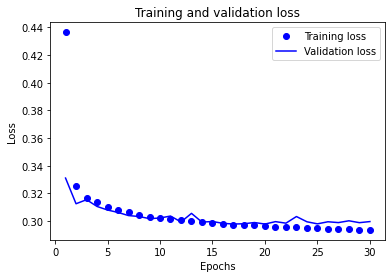

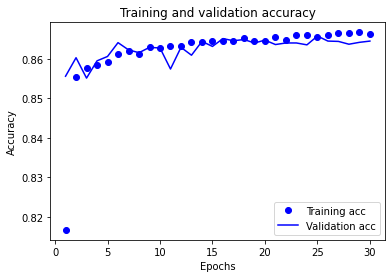

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     11711
           1       0.71      0.64      0.67       546
           2       0.78      0.49      0.60      3479

    accuracy                           0.86     15736
   macro avg       0.79      0.70      0.73     15736
weighted avg       0.85      0.86      0.84     15736



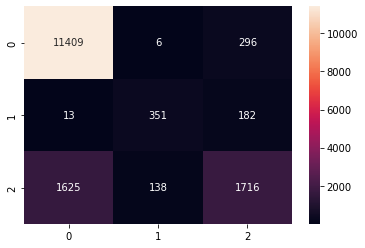

In [117]:
y_pred = np.argmax(m8.predict(X_test), axis=1)
print_training_history(history)
print_evaluation(y_test, y_pred)

## 1*16 Neural Network

In [104]:
# 1*16 neural network
from keras.models import Sequential
from keras.layers import Dense

m16 = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(3, activation="softmax")
])

m16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m16.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1574/1574 [==============================] - 19s 11ms/step - loss: 0.4103 - accuracy: 0.8235 - val_loss: 0.3189 - val_accuracy: 0.8561
Epoch 2/100
1574/1574 [==============================] - 7s 5ms/step - loss: 0.3184 - accuracy: 0.8570 - val_loss: 0.3093 - val_accuracy: 0.8593
Epoch 3/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3114 - accuracy: 0.8587 - val_loss: 0.3068 - val_accuracy: 0.8604
Epoch 4/100
1574/1574 [==============================] - 7s 4ms/step - loss: 0.3081 - accuracy: 0.8607 - val_loss: 0.3051 - val_accuracy: 0.8619
Epoch 5/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3046 - accuracy: 0.8624 - val_loss: 0.3012 - val_accuracy: 0.8622
Epoch 6/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3025 - accuracy: 0.8631 - val_loss: 0.2996 - val_accuracy: 0.8643
Epoch 7/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3006 - accuracy: 0.8637 - val_loss: 0.2999 - val_

492/492 [==============================] - 2s 3ms/step


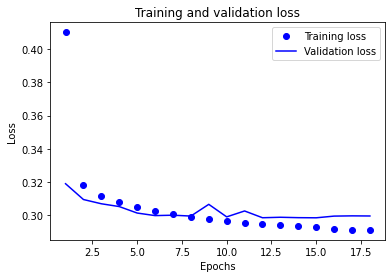

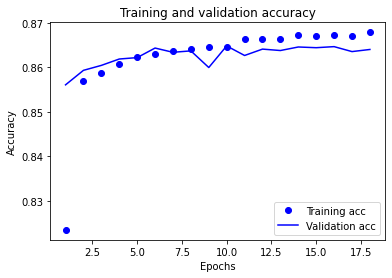

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11711
           1       0.71      0.64      0.67       546
           2       0.78      0.49      0.60      3479

    accuracy                           0.86     15736
   macro avg       0.79      0.70      0.73     15736
weighted avg       0.85      0.86      0.84     15736



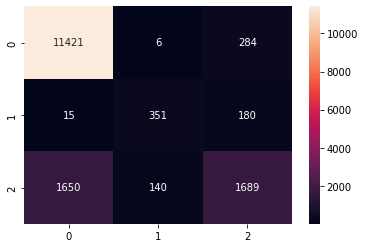

In [105]:
y_pred = np.argmax(m16.predict(X_test), axis=1)
print_training_history(history)
print_evaluation(y_test, y_pred)

## 1*32 Neural Network

In [106]:
# 1*32 neural network
from keras.models import Sequential
from keras.layers import Dense

m32 = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(3, activation="softmax")
])

m32.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m32.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1574/1574 [==============================] - 14s 9ms/step - loss: 0.4010 - accuracy: 0.8270 - val_loss: 0.3196 - val_accuracy: 0.8589
Epoch 2/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3141 - accuracy: 0.8592 - val_loss: 0.3060 - val_accuracy: 0.8625
Epoch 3/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3071 - accuracy: 0.8611 - val_loss: 0.3066 - val_accuracy: 0.8642
Epoch 4/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.3026 - accuracy: 0.8623 - val_loss: 0.3011 - val_accuracy: 0.8651
Epoch 5/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.2998 - accuracy: 0.8634 - val_loss: 0.3057 - val_accuracy: 0.8646
Epoch 6/100
1574/1574 [==============================] - 6s 4ms/step - loss: 0.2972 - accuracy: 0.8646 - val_loss: 0.2985 - val_accuracy: 0.8632
Epoch 7/100
1574/1574 [==============================] - 7s 5ms/step - loss: 0.2949 - accuracy: 0.8657 - val_loss: 0.3076 - val_a

492/492 [==============================] - 2s 3ms/step


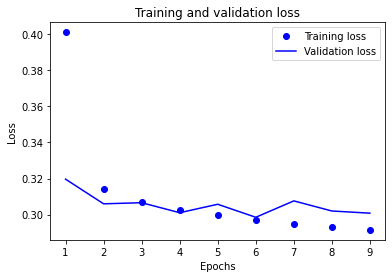

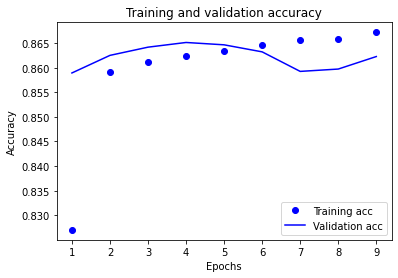

              precision    recall  f1-score   support

           0       0.86      0.99      0.92     11711
           1       0.72      0.61      0.66       546
           2       0.82      0.45      0.58      3479

    accuracy                           0.85     15736
   macro avg       0.80      0.68      0.72     15736
weighted avg       0.85      0.85      0.84     15736



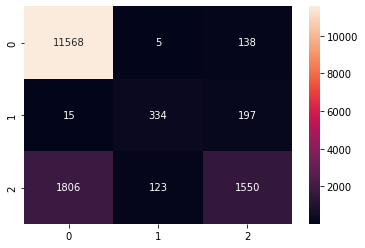

In [107]:
y_pred = np.argmax(m32.predict(X_test), axis=1)

print_training_history(history)
print_evaluation(y_test, y_pred)

## 1*64 Neural Network

In [108]:
# 1*64 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m64 = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])
m64.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = m64.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1574/1574 [==============================] - 17s 10ms/step - loss: 0.4228 - accuracy: 0.8162 - val_loss: 0.3243 - val_accuracy: 0.8556
Epoch 2/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3376 - accuracy: 0.8518 - val_loss: 0.3152 - val_accuracy: 0.8613
Epoch 3/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3300 - accuracy: 0.8558 - val_loss: 0.3118 - val_accuracy: 0.8611
Epoch 4/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3285 - accuracy: 0.8554 - val_loss: 0.3139 - val_accuracy: 0.8601
Epoch 5/100
1574/1574 [==============================] - 7s 4ms/step - loss: 0.3262 - accuracy: 0.8582 - val_loss: 0.3118 - val_accuracy: 0.8627
Epoch 6/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3262 - accuracy: 0.8581 - val_loss: 0.3148 - val_accuracy: 0.8608
Epoch 7/100
1574/1574 [==============================] - 8s 5ms/step - loss: 0.3250 - accuracy: 0.8577 - val_loss: 0.3146 - val_

492/492 [==============================] - 2s 3ms/step


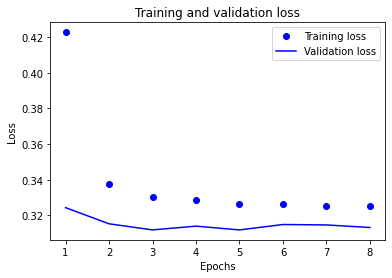

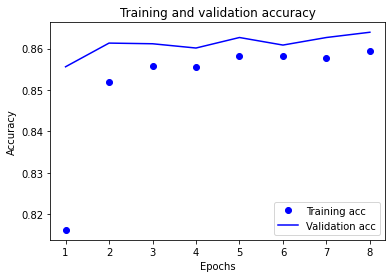

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11711
           1       0.75      0.57      0.65       546
           2       0.80      0.47      0.59      3479

    accuracy                           0.85     15736
   macro avg       0.80      0.67      0.72     15736
weighted avg       0.85      0.85      0.84     15736



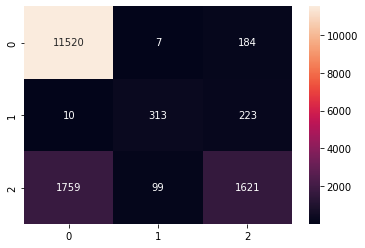

In [109]:
y_pred = np.argmax(m64.predict(X_test), axis=1)

print_training_history(history)
print_evaluation(y_test, y_pred)

## 1 * 128 neural network

In [110]:
m128 = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])
m128.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = m128.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1574/1574 [==============================] - 16s 10ms/step - loss: 0.3977 - accuracy: 0.8264 - val_loss: 0.3159 - val_accuracy: 0.8599
Epoch 2/100
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3294 - accuracy: 0.8529 - val_loss: 0.3154 - val_accuracy: 0.8592
Epoch 3/100
1574/1574 [==============================] - 11s 7ms/step - loss: 0.3253 - accuracy: 0.8569 - val_loss: 0.3088 - val_accuracy: 0.8628
Epoch 4/100
1574/1574 [==============================] - 11s 7ms/step - loss: 0.3227 - accuracy: 0.8584 - val_loss: 0.3138 - val_accuracy: 0.8631
Epoch 5/100
1574/1574 [==============================] - 11s 7ms/step - loss: 0.3228 - accuracy: 0.8586 - val_loss: 0.3108 - val_accuracy: 0.8626
Epoch 6/100
1574/1574 [==============================] - 11s 7ms/step - loss: 0.3211 - accuracy: 0.8597 - val_loss: 0.3130 - val_accuracy: 0.8654


492/492 [==============================] - 2s 5ms/step


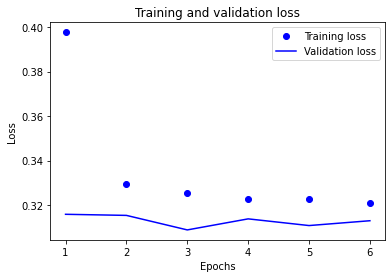

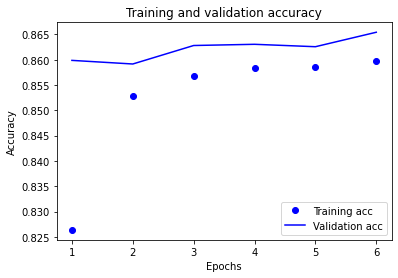

              precision    recall  f1-score   support

           0       0.87      0.99      0.92     11711
           1       0.78      0.57      0.66       546
           2       0.81      0.47      0.59      3479

    accuracy                           0.86     15736
   macro avg       0.82      0.67      0.73     15736
weighted avg       0.85      0.86      0.84     15736



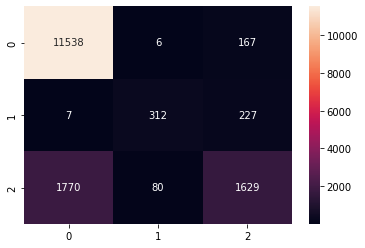

In [111]:
y_pred = np.argmax(m128.predict(X_test), axis=1)

print_training_history(history)
print_evaluation(y_test, y_pred)

## 2 * 4 Neural network

In [112]:
# 2 * 4 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m24 = Sequential([
    Dense(4, input_dim=X_train.shape[1], activation="relu"),
    Dense(4, activation="relu"),
    Dense(3, activation="softmax")
])

m24.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = m24.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1574/1574 [==============================] - 18s 11ms/step - loss: 0.5229 - accuracy: 0.7792 - val_loss: 0.3827 - val_accuracy: 0.8358
Epoch 2/100
1574/1574 [==============================] - 9s 6ms/step - loss: 0.3665 - accuracy: 0.8359 - val_loss: 0.3493 - val_accuracy: 0.8435
Epoch 3/100
1574/1574 [==============================] - 9s 6ms/step - loss: 0.3446 - accuracy: 0.8404 - val_loss: 0.3335 - val_accuracy: 0.8451
Epoch 4/100
1574/1574 [==============================] - 9s 6ms/step - loss: 0.3326 - accuracy: 0.8518 - val_loss: 0.3251 - val_accuracy: 0.8616
Epoch 5/100
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3243 - accuracy: 0.8583 - val_loss: 0.3190 - val_accuracy: 0.8611
Epoch 6/100
1574/1574 [==============================] - 10s 6ms/step - loss: 0.3195 - accuracy: 0.8593 - val_loss: 0.3151 - val_accuracy: 0.8608
Epoch 7/100
1574/1574 [==============================] - 11s 7ms/step - loss: 0.3162 - accuracy: 0.8596 - val_loss: 0.3132 - v

492/492 [==============================] - 2s 3ms/step


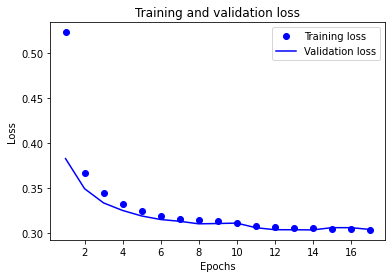

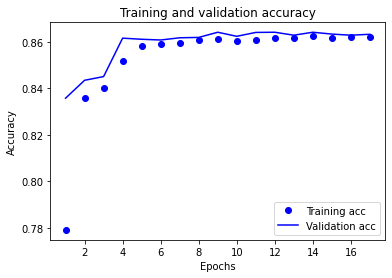

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11711
           1       0.80      0.56      0.66       546
           2       0.79      0.48      0.60      3479

    accuracy                           0.86     15736
   macro avg       0.82      0.68      0.73     15736
weighted avg       0.85      0.86      0.84     15736



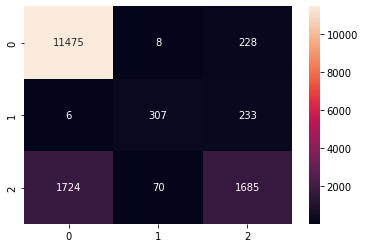

In [113]:
y_pred = np.argmax(m24.predict(X_test), axis=1)

print_training_history(history)
print_evaluation(y_test, y_pred)

# Forward Selection

In [ ]:
# Perform forward feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

lr = LogisticRegression(solver="lbfgs", max_iter=1000)

# forward feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=50, direction="forward", scoring="f1_macro", n_jobs=-1)
sfs.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# print selected features
print("Selected features:", X_train.columns[sfs.get_support()])


Selected features: Index(['most_rcnt_creat', 'tot_serum_album', 'most_rcnt_creat_missing',
       'init_wgt_kg_calc_missing', 'cig_use_missing',
       'work_income_tcr_missing', 'rvad_at_listing_missing',
       'lvad_at_listing_missing', 'cereb_vasc_N', 'cereb_vasc_U',
       'cereb_vasc_Y', 'prior_card_surg_tcr_N', 'prior_card_surg_tcr_U',
       'prior_card_surg_tcr_Y', 'init_stat_2110.0', 'init_stat_2120.0',
       'init_stat_2140.0', 'init_stat_2150.0', 'dial_ty_tcr_3.0',
       'dial_ty_tcr_998.0', 'dial_ty_tcr_999.0', 'malig_tcr_N', 'malig_tcr_U',
       'malig_tcr_Y', 'thoracic_dgn_1201', 'thoracic_dgn_1202',
       'work_income_tcr_N', 'work_income_tcr_U', 'work_income_tcr_Y',
       'diab_998.0', 'func_stat_tcr_3.0', 'func_stat_tcr_996.0',
       'func_stat_tcr_2010.0', 'func_stat_tcr_2100.0',
       'academic_level_tcr_1.0', 'academic_level_tcr_2.0',
       'academic_level_tcr_3.0', 'academic_level_tcr_996.0',
       'academic_level_tcr_998.0', 'education_2.0', 'education_4

In [ ]:
import dill
dill.dump_session("post_forward_selection.db")
#